In [183]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import numpy as np
import pandas as pd
import os, random
from glob import glob
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [184]:
import torch
import torch.nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [185]:
# 데이터셋 루트 폴더
dataset_root = 'C:/Users/User/data/result/'

# 모든 클래스 폴더 가져오기
class_folders = [f for f in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, f))]

# 각 클래스 폴더 내의 이미지 수 계산
total_images = 0
for class_folder in class_folders:
    class_path = os.path.join(dataset_root, class_folder)
    images_in_class = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
    total_images += len(images_in_class)

# 결과 출력
print(f'클래스 폴더 수: {len(class_folders)}')
print(f'총 이미지 수: {total_images}')

클래스 폴더 수: 3
총 이미지 수: 6133


In [186]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

# 이미지의 사이즈를 변환 후 텐서로 변환 
transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor(),
])

#폴더의 이미지를 로딩, 라벨링
image_dataset = ImageFolder(root='C:/Users/User/data/result/', transform=transforms)
#train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=3)
train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size
batch_size = 32
train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=4)


In [187]:
print("training set : ", len(train_loader)*batch_size)
print("test set : " , len(test_loader)*batch_size)

training set :  4928
test set :  1248


In [188]:
class_names = image_dataset.classes
# 학습 결과 시각화
train_losses = []  # 학습 손실값을 기록할 리스트
train_accuracies = []  # 학습 정확도를 기록할 리스트
test_losses = []
test_accuracies = []
save_interval = 1

# 에포크마다 모델 저장을 위한 경로와 파일명 지정
model_save_path = 'C:/Users/User/Desktop/model_result/models'  # 저장할 디렉토리 경로
model_name = 'model'  # 저장할 모델 파일명 (에포크 번호가 자동으로 붙음)

# 저장할 폴더가 없다면 생성
os.makedirs(model_save_path, exist_ok=True)

In [189]:
class CNNModel(nn.Module) :
    # 모델의 레이어
    def __init__(self, num_classes) :
        super(CNNModel, self).__init__()
        #4개의 합성곱, 풀링 레이어(pool), 완전연결레이어(fc1), 과적합 방지(dropout) 추가
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        #self.bn1 = nn.BatchNorm2d(12)
        #self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.bn2 = nn.BatchNorm2d(48)
        #self.pool2 = nn.MaxPool2d(2 , 2)
        self.dropout1 = nn.Dropout(0.2)
        #self.conv4 = nn.Conv2d(32 ,64, kernel_size=3, stride=1, padding=1)
        #self.bn4 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #self.dropout2 = nn.Dropout(0.2)
        #self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        #self.bn5 = nn.BatchNorm2d(128)
        #self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 4, num_classes) #이미지 사이즈가 128x128로 변경됨

    # 입력데이터의 연산 수행 후 출력
    def forward(self, input):
        output = self.pool3(F.relu(self.conv1(input)))
        #output = self.pool1(output)
        output = self.pool3(F.relu(self.conv2(output)))
        #output = self.pool2(output)
        output = F.relu(self.dropout1(output))
        #output = self.pool2(output)
        #output = F.relu(self.bn4(self.conv4(output)))
        #output = self.pool3(output)
        #output = F.relu(self.dropout2(output))
        #output = F.relu(self.bn5(self.conv5(output)))
        #output = self.pool4(output)

        # Global Average Pooling
        #output = F.adaptive_avg_pool2d(output, (1, 1))

        # 변경된 부분: 이전에는 128*128*128이었지만, 이제는 128이 됩니다.
        output = output.view(-1, 64 * 64 * 4)
        output = self.fc1(output)

        return output

model = CNNModel(num_classes=3)
model.to(device)


#다중클래스 분류에서 사용하는 손실함수
criterion = nn.CrossEntropyLoss()
# 알고리즘(adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for param_tensor in model.state_dict() :
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([3, 16384])
fc1.bias 	 torch.Size([3])


In [190]:
#학습 수행(epoch = 30)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    accuracy = 0
    total = 0
    test_total = 0
    test_loss = 0

    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    with torch.no_grad() :
        for data in test_loader :
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total


    test_accuracy = 100 * accuracy / test_total
    test_loss = test_loss / len(test_loader)


    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test_Loss: {test_loss:.4f}, Test_Acc: {test_accuracy:.2f}%")

    # if (epoch + 1) % save_interval == 0:
    #     model_filename = f'{model_name}10_epoch_{epoch+1}.pt'
    #     model_filepath = os.path.join(model_save_path, model_filename)
    #     torch.save(model.state_dict(), model_filepath)

Epoch [1/20] - Loss: 0.9885, Accuracy: 52.32%, Test_Loss: 0.9494, Test_Acc: 54.36%
Epoch [2/20] - Loss: 0.9238, Accuracy: 55.91%, Test_Loss: 0.9075, Test_Acc: 54.85%
Epoch [3/20] - Loss: 0.8744, Accuracy: 58.07%, Test_Loss: 0.8702, Test_Acc: 57.54%
Epoch [4/20] - Loss: 0.8432, Accuracy: 59.17%, Test_Loss: 0.8427, Test_Acc: 58.19%
Epoch [5/20] - Loss: 0.8240, Accuracy: 59.64%, Test_Loss: 0.8211, Test_Acc: 58.76%
Epoch [6/20] - Loss: 0.8085, Accuracy: 60.68%, Test_Loss: 0.7982, Test_Acc: 61.94%
Epoch [7/20] - Loss: 0.7985, Accuracy: 61.82%, Test_Loss: 0.8027, Test_Acc: 61.53%
Epoch [8/20] - Loss: 0.7818, Accuracy: 62.29%, Test_Loss: 0.7780, Test_Acc: 61.94%
Epoch [9/20] - Loss: 0.7768, Accuracy: 62.64%, Test_Loss: 0.7640, Test_Acc: 64.96%
Epoch [10/20] - Loss: 0.7505, Accuracy: 64.19%, Test_Loss: 0.7542, Test_Acc: 65.20%
Epoch [11/20] - Loss: 0.7455, Accuracy: 65.35%, Test_Loss: 0.7607, Test_Acc: 63.24%
Epoch [12/20] - Loss: 0.7367, Accuracy: 65.43%, Test_Loss: 0.7667, Test_Acc: 64.96%
E

In [191]:
model_filepath = os.path.join(model_save_path, 'model.pt')
torch.save(model, model_filepath)

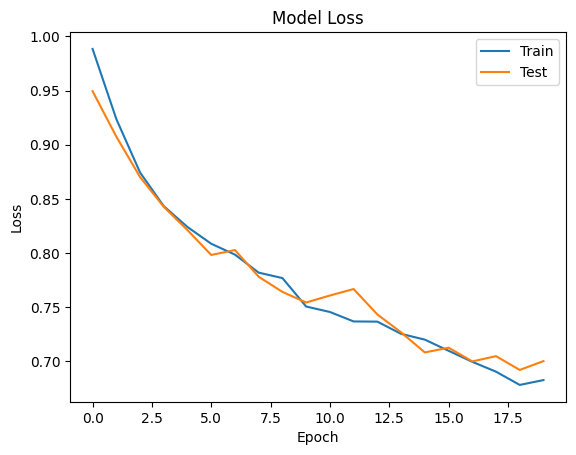

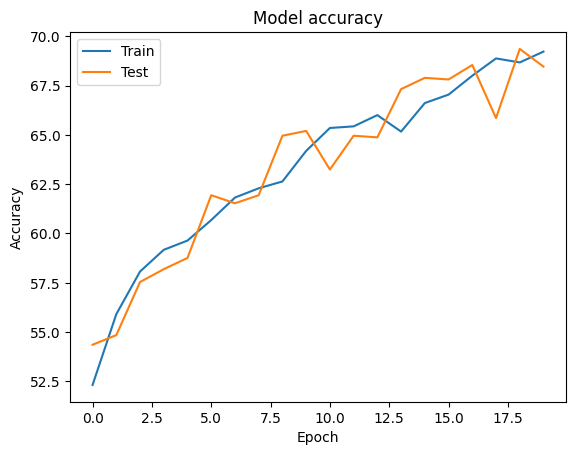

In [195]:

def plt_show_loss(losses) :
    plt.plot(losses, label = ['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

def plt_show_acc(accuracies) :
    plt.plot(accuracies, label = ['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

plt_show_loss(train_losses)
plt_show_loss(test_losses)
plt.show()

plt_show_acc(train_accuracies)
plt_show_acc(test_accuracies)
plt.show()

In [193]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import glob


# 폴더 내의 모든 이미지 파일 경로 가져오기
folder_path = "C:/Users/User/Desktop/bigdata/imgs/test/"  # 이미지 폴더 경로
image_files = glob.glob(os.path.join(folder_path, "*.jpg"))  # jpg 확장자를 가진 이미지 파일들의 경로 리스트
class_names = ["Delphinus", "Mink", "Porpoise"]

# 모델을 eval 상태로 설정
model.eval()

# 변환 함수 정의
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

results_df = pd.DataFrame(columns=["File Name", "Predicted Class", "Probability"])

for img_path in image_files:
    #파일명 추출
    file_name = os.path.basename(img_path)

    # 이미지 불러오기
    img = Image.open(img_path)
    img = preprocess(img)
    img = torch.unsqueeze(img, 0)
    img = img.to(device)

    # 모델로 예측하기
    with torch.no_grad():
        predictions = model(img)
        predictions = F.softmax(predictions[0], dim=0) * 100
        class_probs = [prob.item() for prob in predictions]

    # 파일명 출력
    print(f"File Name: {file_name}")

    

    # 예측 결과 출력
    for i, class_name in enumerate(class_names):
        print(f"Class: {class_name}, Probability: {class_probs[i]:.2f}%")
        
    predicted_class = torch.argmax(predictions).item()
    print(f"Predicted Class: {class_names[predicted_class]}")
    print("="*30)

    # 예측 결과를 데이터프레임에 추가
    result_row = {
        "File Name": file_name,
        "Predicted Class": class_names[predicted_class],
        "Probability": class_probs[predicted_class]
    }

    result_df = pd.DataFrame([result_row])
    results_df = pd.concat([results_df, result_df], ignore_index=True)

# 결과를 엑셀 파일로 저장
results_df.to_excel("predictions.xlsx", index=False)

File Name: 1 (2).jpg
Class: Delphinus, Probability: 0.19%
Class: Mink, Probability: 73.07%
Class: Porpoise, Probability: 26.74%
Predicted Class: Mink
File Name: 1 (3).jpg
Class: Delphinus, Probability: 8.31%
Class: Mink, Probability: 53.76%
Class: Porpoise, Probability: 37.93%
Predicted Class: Mink
File Name: 1 (5).jpg
Class: Delphinus, Probability: 0.97%
Class: Mink, Probability: 70.21%
Class: Porpoise, Probability: 28.81%
Predicted Class: Mink
File Name: 1 (6).jpg
Class: Delphinus, Probability: 8.19%
Class: Mink, Probability: 15.49%
Class: Porpoise, Probability: 76.32%
Predicted Class: Porpoise
File Name: 1(1).jpg
Class: Delphinus, Probability: 4.97%
Class: Mink, Probability: 43.96%
Class: Porpoise, Probability: 51.07%
Predicted Class: Porpoise
File Name: cham_20231025155647_10.jpg
Class: Delphinus, Probability: 0.02%
Class: Mink, Probability: 88.24%
Class: Porpoise, Probability: 11.74%
Predicted Class: Mink
File Name: cham_20231025155648_11.jpg
Class: Delphinus, Probability: 1.41%
C

C:\Users\User\AppData\Local\Temp\ipykernel_28976\3299621828.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_df], ignore_index=True)


File Name: Minke whale_365.jpg
Class: Delphinus, Probability: 12.24%
Class: Mink, Probability: 26.97%
Class: Porpoise, Probability: 60.79%
Predicted Class: Porpoise
File Name: Minke whale_367.jpg
Class: Delphinus, Probability: 1.26%
Class: Mink, Probability: 69.95%
Class: Porpoise, Probability: 28.80%
Predicted Class: Mink
File Name: Minke whale_368.jpg
Class: Delphinus, Probability: 13.88%
Class: Mink, Probability: 24.92%
Class: Porpoise, Probability: 61.20%
Predicted Class: Porpoise
File Name: Minke whale_369.jpg
Class: Delphinus, Probability: 5.57%
Class: Mink, Probability: 43.13%
Class: Porpoise, Probability: 51.30%
Predicted Class: Porpoise
File Name: Minke whale_377.jpg
Class: Delphinus, Probability: 5.26%
Class: Mink, Probability: 65.90%
Class: Porpoise, Probability: 28.84%
Predicted Class: Mink
File Name: Minke whale_398.jpg
Class: Delphinus, Probability: 6.66%
Class: Mink, Probability: 27.85%
Class: Porpoise, Probability: 65.49%
Predicted Class: Porpoise
File Name: Minke whale